# <h1 align=center>Emotion Recognition</h1>

In [18]:
import numpy as np 
import pandas as pd 
import os

import tensorflow as tf
from tensorflow.keras.layers import Permute,Dense,Flatten,Conv2D,Resizing,Rescaling,Input,Dropout,InputLayer,MaxPool2D,BatchNormalization,RandomContrast,RandomFlip,RandomRotation,MaxPooling2D,Activation,GlobalAveragePooling2D,Add,Embedding,LayerNormalization,MultiHeadAttention
from tensorflow.keras.regularizers import L2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
import kagglehub
import pathlib

In [19]:
# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

100%|██████████| 309M/309M [00:31<00:00, 10.2MB/s] 

Extracting files...


Path to dataset files: C:\Users\Valentina\.cache\kagglehub\datasets\muhammadhananasghar\human-emotions-datasethes\versions\4


In [24]:
train_directory='EmotionsDataset_Splitted/train'
val_directory="EmotionsDataset_Splitted/test"
CLASS_NAMES=['angry','happy','sad']

In [21]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
}

In [34]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


In [35]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 569 files belonging to 3 classes.


In [36]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
#     "N_EPOCHS": 20,
    "N_EPOCHS": 5,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [37]:
train = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [38]:
val = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 569 files belonging to 3 classes.


In [39]:
for i in val_dataset. take (1) :
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[255.      , 255.      , 251.      ],
         [255.      , 255.      , 251.      ],
         [255.      , 254.3125  , 251.6875  ],
         ...,
         [ 58.      ,  46.625   ,  46.3125  ],
         [ 54.4375  ,  44.4375  ,  43.4375  ],
         [ 39.      ,  29.      ,  28.      ]],

        [[255.      , 255.      , 251.      ],
         [255.      , 255.      , 251.      ],
         [253.88281 , 253.19531 , 250.57031 ],
         ...,
         [ 58.8125  ,  47.4375  ,  47.125   ],
         [ 55.859375,  45.859375,  44.859375],
         [ 43.0625  ,  33.0625  ,  32.0625  ]],

        [[255.      , 255.      , 251.      ],
         [255.      , 255.      , 251.      ],
         [253.625   , 253.41016 , 250.78516 ],
         ...,
         [ 59.214844,  47.839844,  47.527344],
         [ 57.132812,  47.132812,  46.132812],
         [ 46.0625  ,  36.0625  ,  35.0625  ]],

        ...,

        [[252.3125  , 254.3125  

In [40]:
for images, labels in val_dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (32, 256, 256, 3)
Labels shape: (32, 3)


##### DATA VISUALIZATION

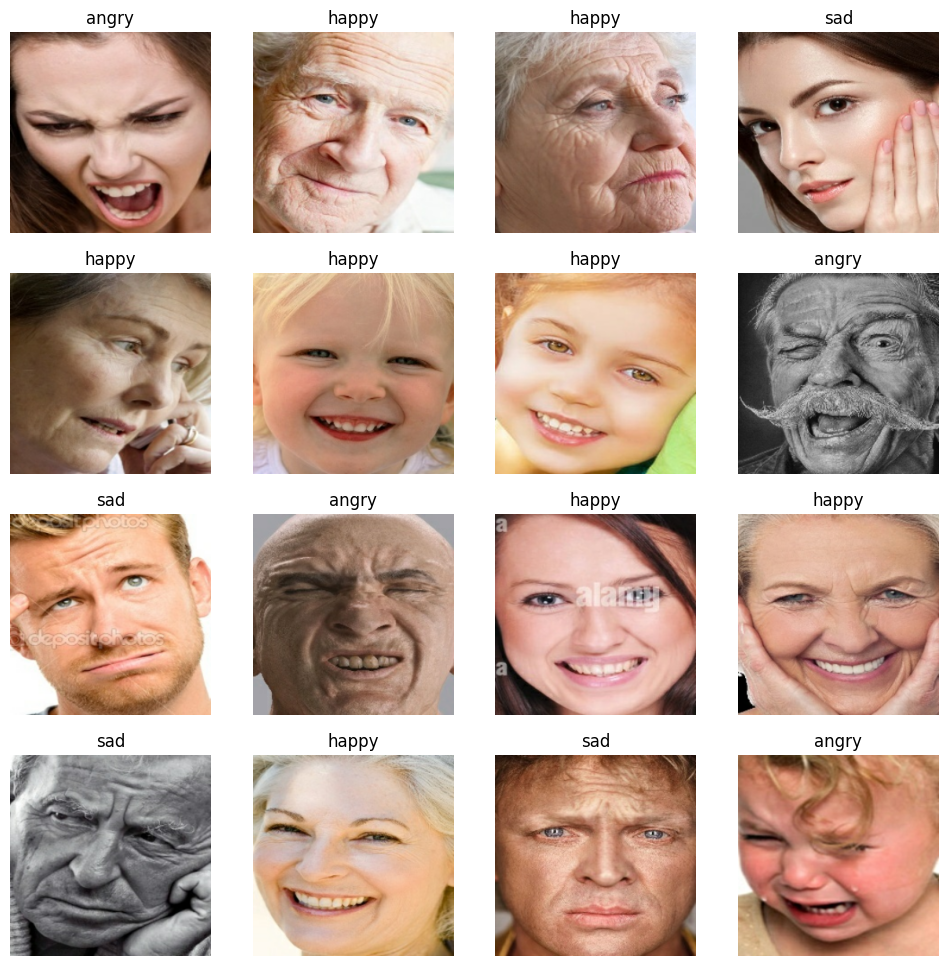

In [42]:
plt.figure(figsize=(12,12))
for images,labels in train_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255)
        plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0)])
        plt.axis('off')

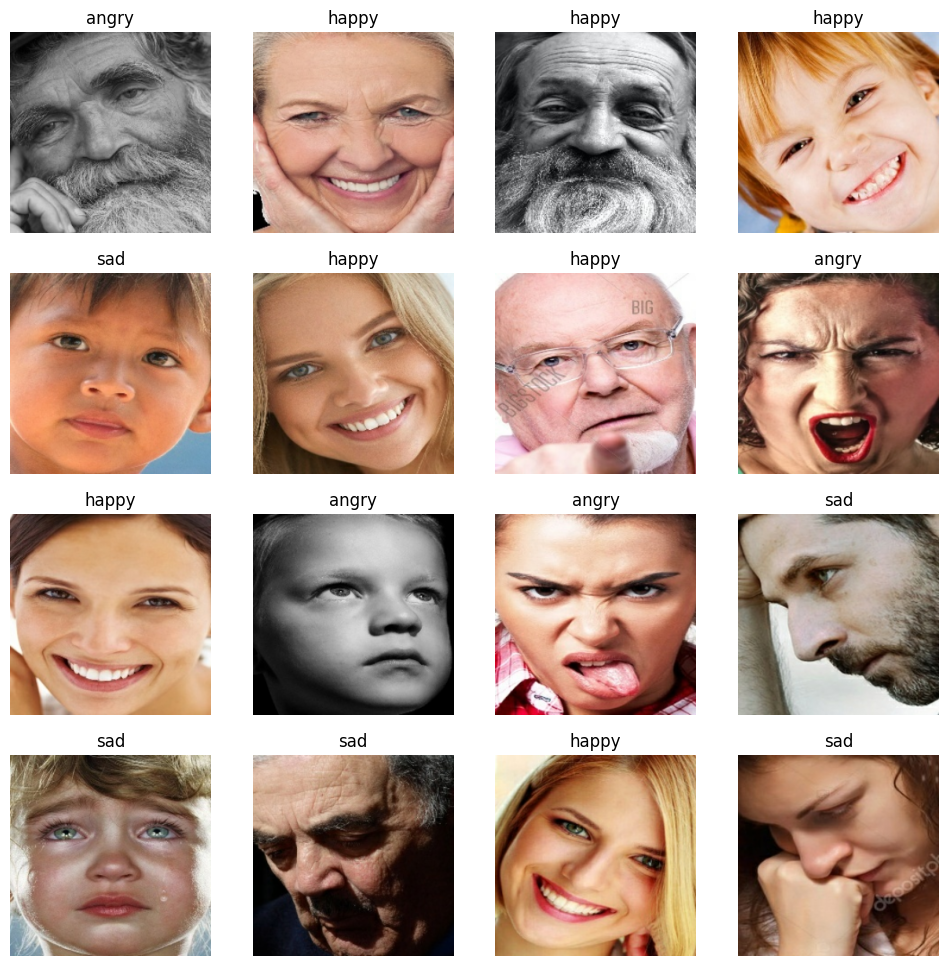

In [44]:
plt. figure(figsize = (12,12))
for images, labels in train_dataset. take (1) :
    for i in range (16):
        ax = plt.subplot(4,4, i+1)
        plt. imshow(images[i]/255)
        plt. title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy ()])
        plt.axis ("off")

In [ ]:
import numpy as np 
import pandas as pd 
import os

import tensorflow as tf
from tensorflow.keras.layers import Permute,Dense,Flatten,Conv2D,Resizing,Rescaling,Input,Dropout,InputLayer,MaxPool2D,BatchNormalization,RandomContrast,RandomFlip,RandomRotation,MaxPooling2D,Activation,GlobalAveragePooling2D,Add,Embedding,LayerNormalization,MultiHeadAttention
from tensorflow.keras.regularizers import L2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
import kagglehub
import pathlib

In [ ]:
print("\nTraining dataset\n")
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")
print("\nTest dataset\n")
for expression in os.listdir("test/"):
    print(str(len(os.listdir("test/" + expression))) + " " + expression + " images")


Training dataset

1 angry images
1 disgust images
1 fear images
1 happy images
1 neutral images
1 sad images
1 surprise images

Test dataset

1 test images


In [ ]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(
    rescale=1./255,  # Esto normaliza las imágenes
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=False)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=False)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 1 classes.


In [ ]:
# Verificar las primeras etiquetas generadas por el generador
print(train_generator.class_indices)
batch = next(train_generator)
print(batch[1])  

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
[6. 3. 5. 5. 5. 0. 0. 4. 6. 5. 6. 4. 0. 3. 3. 5. 3. 2. 2. 6. 3. 0. 3. 5.
 4. 3. 2. 3. 0. 5. 3. 6. 3. 4. 4. 0. 0. 0. 3. 3. 2. 2. 3. 5. 3. 3. 5. 5.
 0. 4. 3. 3. 0. 2. 5. 0. 6. 3. 3. 2. 5. 0. 5. 4.]


In [ ]:
x_batch, y_batch = next(train_generator)
print(f"x_batch shape: {x_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

x_batch shape: (64, 48, 48, 1)
y_batch shape: (64,)


In [ ]:
# Definición del modelo
model = Sequential()

# Primera capa de convolución
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Segunda capa de convolución
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Tercera capa de convolución
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Cuarta capa de convolución
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Aplanado y capas densas
model.add(Flatten())

# Primera capa densa
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Segunda capa densa
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Capa de salida
model.add(Dense(7, activation='softmax'))  # Número de clases (7 en este caso)

# Compilación del modelo
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,02

 Total params: 3,002,887 (11.46 MB)

 Trainable params: 2,999,431 (11.44 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [ ]:
# condiciones de parada temprana
earlystop_acc = EarlyStopping(monitor="val_accuracy",
                                  min_delta=0.001,
                                  patience=10,
                                  mode="max",
                                  restore_best_weights=True)

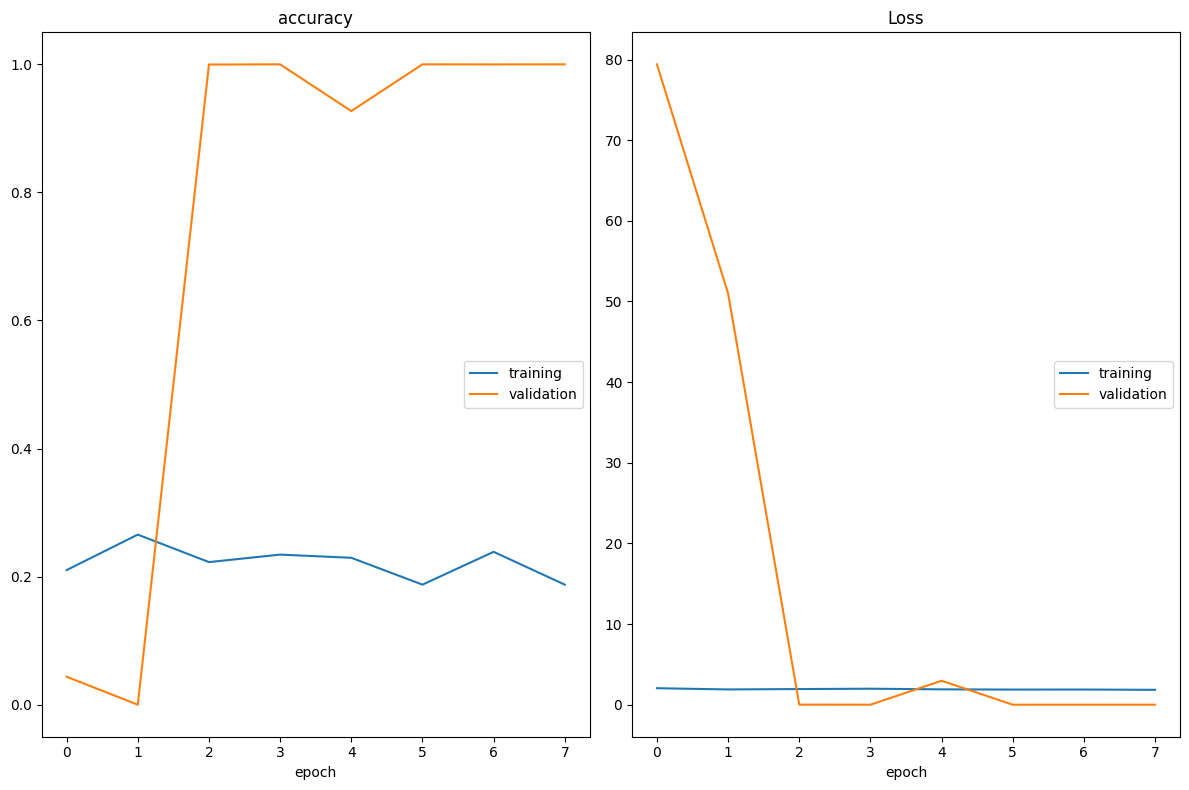

accuracy
	training         	 (min:    0.188, max:    0.266, cur:    0.188)
	validation       	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    1.845, max:    2.044, cur:    1.845)
	validation       	 (min:    0.000, max:   79.404, cur:    0.000)

Epoch 8: val_accuracy did not improve from 1.00000
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1875 - loss: 1.8451 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 9/15
182/448 ━━━━━━━━━━━━━━━━━━━━ 4:53 1s/step - accuracy: 0.2426 - loss: 1.8648

KeyboardInterrupt: 

In [ ]:
# Configuración de entrenamiento
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, mode='auto', verbose=1
)

checkpoint = ModelCheckpoint(
    "best_model.keras", monitor='val_accuracy', save_weights_only=False,
    mode='max', verbose=1, save_best_only=True
)

callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr, earlystop_acc]

# Medición del tiempo de entrenamiento
start_time = time.time()

# Entrenamiento del modelo
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Mostrar tiempo de entrenamiento
end_time = time.time()
print("Tiempo total de entrenamiento:", end_time - start_time, "segundos")

In [9]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(
    rescale=1./255,  # Esto normaliza las imágenes
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=False)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=False)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 1 classes.


In [10]:
# Verificar las primeras etiquetas generadas por el generador
print(train_generator.class_indices)
batch = next(train_generator)
print(batch[1])  

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
[6. 3. 5. 5. 5. 0. 0. 4. 6. 5. 6. 4. 0. 3. 3. 5. 3. 2. 2. 6. 3. 0. 3. 5.
 4. 3. 2. 3. 0. 5. 3. 6. 3. 4. 4. 0. 0. 0. 3. 3. 2. 2. 3. 5. 3. 3. 5. 5.
 0. 4. 3. 3. 0. 2. 5. 0. 6. 3. 3. 2. 5. 0. 5. 4.]


In [11]:
x_batch, y_batch = next(train_generator)
print(f"x_batch shape: {x_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

x_batch shape: (64, 48, 48, 1)
y_batch shape: (64,)


In [12]:
# Definición del modelo
model = Sequential()

# Primera capa de convolución
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Segunda capa de convolución
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Tercera capa de convolución
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Cuarta capa de convolución
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Aplanado y capas densas
model.add(Flatten())

# Primera capa densa
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Segunda capa densa
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Capa de salida
model.add(Dense(7, activation='softmax'))  # Número de clases (7 en este caso)

# Compilación del modelo
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,02

 Total params: 3,002,887 (11.46 MB)

 Trainable params: 2,999,431 (11.44 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [13]:
# condiciones de parada temprana
earlystop_acc = EarlyStopping(monitor="val_accuracy",
                                  min_delta=0.001,
                                  patience=10,
                                  mode="max",
                                  restore_best_weights=True)

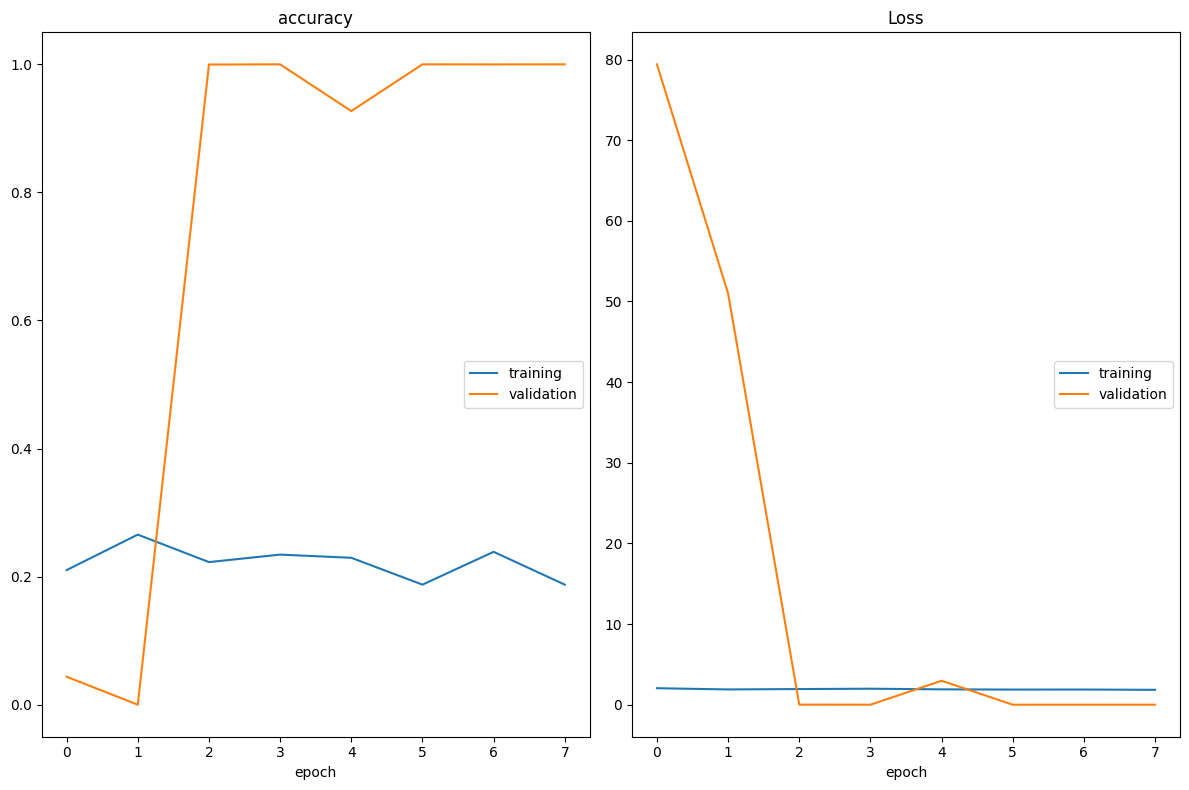

accuracy
	training         	 (min:    0.188, max:    0.266, cur:    0.188)
	validation       	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    1.845, max:    2.044, cur:    1.845)
	validation       	 (min:    0.000, max:   79.404, cur:    0.000)

Epoch 8: val_accuracy did not improve from 1.00000
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1875 - loss: 1.8451 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 9/15
182/448 ━━━━━━━━━━━━━━━━━━━━ 4:53 1s/step - accuracy: 0.2426 - loss: 1.8648

KeyboardInterrupt: 

In [14]:
# Configuración de entrenamiento
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, mode='auto', verbose=1
)

checkpoint = ModelCheckpoint(
    "best_model.keras", monitor='val_accuracy', save_weights_only=False,
    mode='max', verbose=1, save_best_only=True
)

callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr, earlystop_acc]

# Medición del tiempo de entrenamiento
start_time = time.time()

# Entrenamiento del modelo
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Mostrar tiempo de entrenamiento
end_time = time.time()
print("Tiempo total de entrenamiento:", end_time - start_time, "segundos")